In [25]:
import keras
import tensorflow as tf
import gdal
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

In [26]:
image_dir = Path(r'/media/hkropp/research/milkweed/training/img_g22')
milk_dir = Path(r'/media/hkropp/research/milkweed/training/masks_g22')

In [27]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [28]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [29]:
import typing as t

def load_image_rgb(path: str, shape: t.Tuple[int,int,int], dtype) -> np.ndarray:
    image = np.zeros(shape = shape, dtype=dtype)
    ds= gdal.Open(path, gdal.GA_ReadOnly)
    for i in (1, 2, 3):
        image[:, :, i-1] = ds.GetRasterBand(i).ReadAsArray()
    return image


In [30]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [31]:
def load_stack_rgb(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        # subsets for rgb bands only
        stack[i, :, :, :] = load_image_rgb(image_path, (shape[1], shape[2], shape[3]), dtype)
    return stack

# need to skip when there is no mask
# loads single band mask
def load_stack_safely(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        if not os.path.isfile(image_path):
            print("skipping", image_path)
            continue
        stack[i, :, :] = load_image(image_path)
    return stack

In [32]:
# training total data size
I = 377
# image dim 1
N = 256
# image dim 2
M = 256
# number of image bands
L = 3
# number of classes
V = 1

In [33]:
train_images = load_stack_rgb((I, N, M, L), np.int8, image_dir, "img")
train_images_R = train_images.reshape(I, N, M, L)

In [34]:
train_images_R.shape

(377, 256, 256, 3)

In [35]:
test = gdal.Open(r'/media/hkropp/research/milkweed/training/img_g22/img_1.tif', gdal.GA_ReadOnly)

In [36]:
test

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f302f4a3a20> >

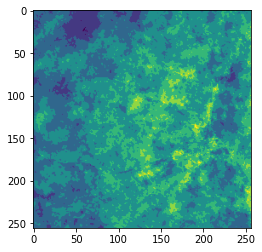

In [37]:
plt.imshow(test.GetRasterBand(3).ReadAsArray())

In [38]:
milk_mask = load_stack_safely((I, N, M), np.int8, milk_dir, "milkweed")

skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_1.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_2.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_3.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_4.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_5.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_6.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_7.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_8.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_9.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_10.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_11.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_12.tif
skipping /media/hkropp/research/milkweed/training/masks_g22/milkweed_13.tif
skipping /media/hkrop

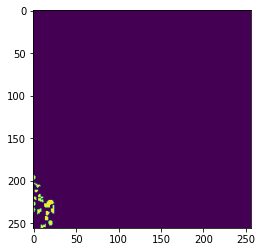

In [39]:
plt.imshow(milk_mask[13, :,:])

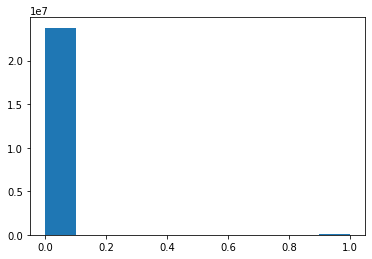

In [40]:
plt.hist(milk_mask[13:,:].flatten())
plt.show()

In [41]:
# alter unet code from package
from keras_unet import TF
if TF:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )
else:    
    from keras.models import Model
    from keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )


def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet2(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (5,5)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [76]:
model = satellite_unet2((N, M, 3), V)

In [77]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = [iou, iou_thresholded],
)

In [78]:
history = model.fit(train_images_R, milk_mask, epochs = 100)

Epoch 1/100
12/12 [==============================] - 283s 22s/step - loss: 0.2079 - iou: 0.0057 - iou_thresholded: 0.0036
Epoch 2/100
12/12 [==============================] - 266s 22s/step - loss: 0.0192 - iou: 0.0207 - iou_thresholded: 0.0053
Epoch 3/100
12/12 [==============================] - 267s 22s/step - loss: 0.0158 - iou: 0.0256 - iou_thresholded: 0.0115
Epoch 4/100
12/12 [==============================] - 263s 22s/step - loss: 0.0141 - iou: 0.0389 - iou_thresholded: 0.0114
Epoch 5/100
12/12 [==============================] - 265s 22s/step - loss: 0.0133 - iou: 0.0529 - iou_thresholded: 0.0381
Epoch 6/100
12/12 [==============================] - 266s 22s/step - loss: 0.0151 - iou: 0.0453 - iou_thresholded: 0.0388
Epoch 7/100
12/12 [==============================] - 261s 22s/step - loss: 0.0136 - iou: 0.0452 - iou_thresholded: 0.0363
Epoch 8/100
12/12 [==============================] - 263s 22s/step - loss: 0.0140 - iou: 0.0441 - iou_thresholded: 0.0514
Epoch 9/100
12/12 [=====

12/12 [==============================] - 98s 8s/step - loss: 0.0086 - iou: 0.1204 - iou_thresholded: 0.0676
Epoch 69/100
12/12 [==============================] - 100s 8s/step - loss: 0.0087 - iou: 0.1306 - iou_thresholded: 0.1079
Epoch 70/100
12/12 [==============================] - 101s 8s/step - loss: 0.0096 - iou: 0.0846 - iou_thresholded: 0.0251
Epoch 71/100
12/12 [==============================] - 103s 9s/step - loss: 0.0086 - iou: 0.1233 - iou_thresholded: 0.1056
Epoch 72/100
12/12 [==============================] - 102s 8s/step - loss: 0.0078 - iou: 0.1327 - iou_thresholded: 0.1371
Epoch 73/100
12/12 [==============================] - 102s 8s/step - loss: 0.0077 - iou: 0.1347 - iou_thresholded: 0.1104
Epoch 74/100
12/12 [==============================] - 102s 8s/step - loss: 0.0083 - iou: 0.1388 - iou_thresholded: 0.1205
Epoch 75/100
12/12 [==============================] - 101s 8s/step - loss: 0.0076 - iou: 0.1448 - iou_thresholded: 0.1439
Epoch 76/100
12/12 [==================

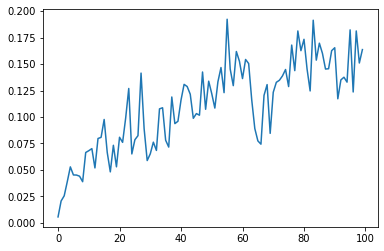

In [79]:
plt.plot(history.history['iou'])

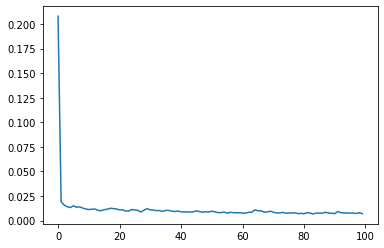

In [80]:
plt.plot(history.history['loss'])

In [81]:
modelsave_path = Path(r'/media/hkropp/research/milkweed/model/m_k5_r2')

In [82]:
model.save(modelsave_path)

INFO:tensorflow:Assets written to: /media/hkropp/research/milkweed/model/m_k5_r2/assets


INFO:tensorflow:Assets written to: /media/hkropp/research/milkweed/model/m_k5_r2/assets


In [83]:
Y_pred = model.predict(train_images_R)

12/12 [==============================] - 36s 3s/step


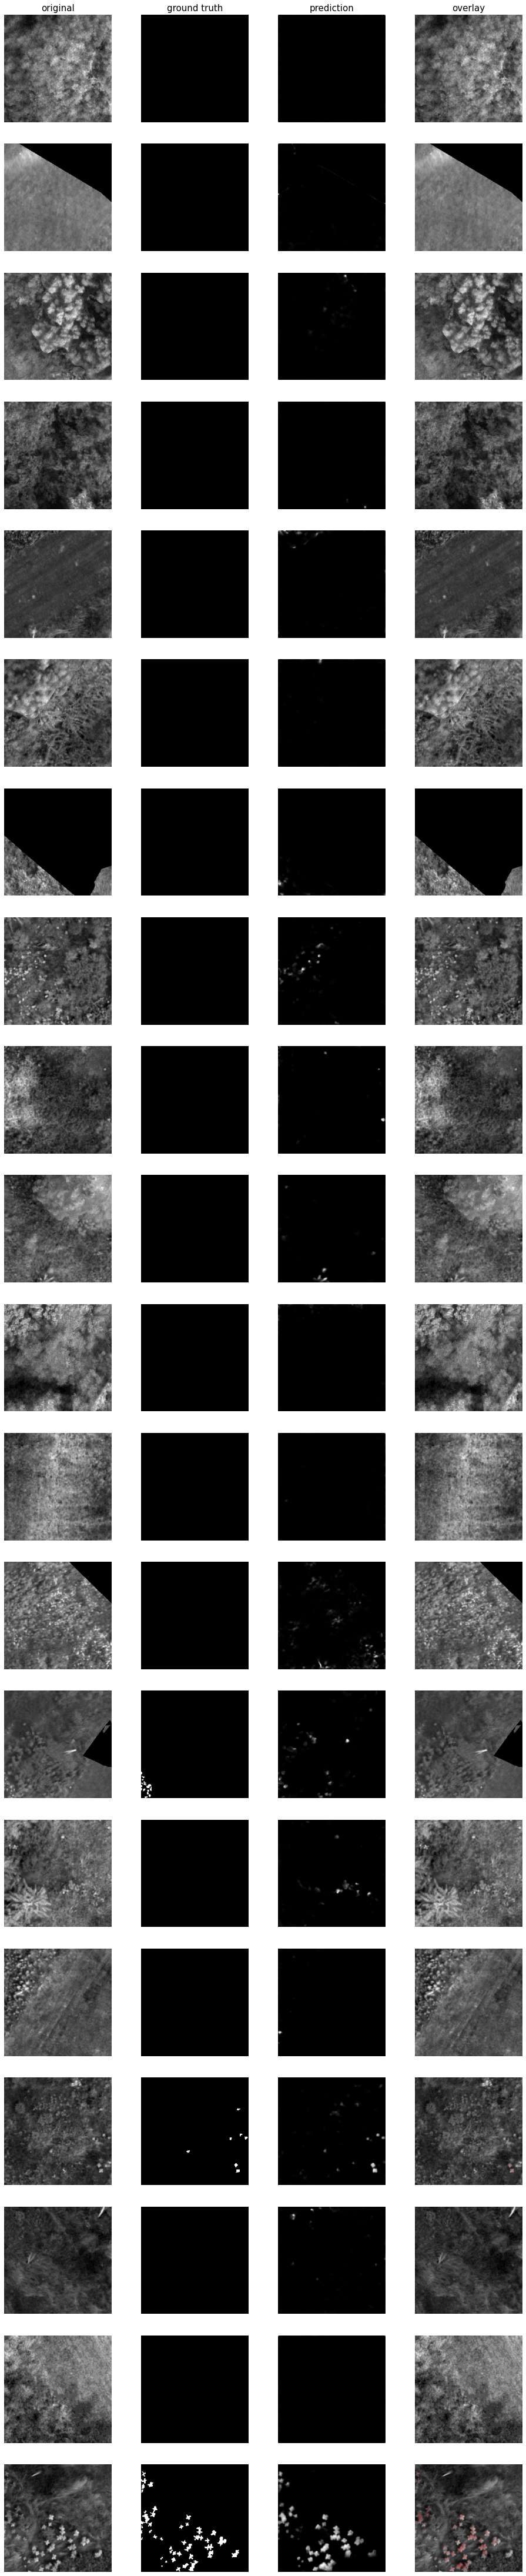

In [84]:
from keras_unet.utils import plot_imgs

# milkweed
plot_imgs(
    org_imgs=train_images_R.reshape(I, N, M, 3)[:,:,:,1], 
    mask_imgs=milk_mask[:, :, :], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=20
  )

In [85]:
milk_mask.shape

(377, 256, 256)

In [86]:
base_dirP = r'/media/hkropp/research/milkweed/tile_07_22_22'
tiles = os.listdir(base_dirP)

T = len(tiles)


In [87]:
T

526

In [88]:
tiles

['img851.tif',
 'img285.tif',
 'img456.tif',
 'img19.tif',
 'img228.tif',
 'img337.tif',
 'img382.tif',
 'img889.tif',
 'img450.tif',
 'img298.tif',
 'img914.tif',
 'img266.tif',
 'img698.tif',
 'img455.tif',
 'img361.tif',
 'img820.tif',
 'img672.tif',
 'img300.tif',
 'img137.tif',
 'img490.tif',
 'img977.tif',
 'img113.tif',
 'img513.tif',
 'img614.tif',
 'img255.tif',
 'img458.tif',
 'img328.tif',
 'img208.tif',
 'img417.tif',
 'img199.tif',
 'img484.tif',
 'img49.tif',
 'img605.tif',
 'img362.tif',
 'img492.tif',
 'img486.tif',
 'img860.tif',
 'img420.tif',
 'img327.tif',
 'img707.tif',
 'img520.tif',
 'img430.tif',
 'img525.tif',
 'img787.tif',
 'img512.tif',
 'img144.tif',
 'img632.tif',
 'img613.tif',
 'img521.tif',
 'img916.tif',
 'img314.tif',
 'img52.tif',
 'img761.tif',
 'img269.tif',
 'img646.tif',
 'img141.tif',
 'img980.tif',
 'img481.tif',
 'img480.tif',
 'img526.tif',
 'img263.tif',
 'img734.tif',
 'img51.tif',
 'img462.tif',
 'img197.tif',
 'img201.tif',
 'img233.tif',

In [89]:
# check for partial tiles
imgD1 = np.zeros((T,2), dtype=int)

for i in range(T):
    tileLoad = gdal.Open(os.path.join(base_dirP, tiles[i]), gdal.GA_ReadOnly)
    tileAr = np.array(tileLoad.GetRasterBand(1).ReadAsArray())
    imgD1[i,0] = tileAr.shape[0]
    imgD1[i,1] = tileAr.shape[1]

In [90]:
# check for partial tiles

imgFlag = np.zeros((T), dtype=int)

for i in range(T):
    if imgD1[i,0] < 256 or imgD1[i,1] < 256:
        imgFlag[i] = 1
    else:
        imgFlag[i] = 0

imgTable = np.zeros((T,1), dtype=int)
for i in range(T):
    imgTable[i,0] = imgFlag[i]


In [91]:
def load_stack_rgb_tile(shape, dtype, img_dir, file, imgFlag):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = os.path.join(img_dir, file[i])
        # subsets for rgb bands only
        imageT = gdal.Open(os.path.join(base_dirP, tiles[i]), gdal.GA_ReadOnly)
        if imgFlag[i,0] == 1:
            print("nullified", image_path)
            stack[i,:,:,:] = np.nan
        else:
            for k in (1, 2, 3):
                stack[i, :, :, k-1] = np.array(imageT.GetRasterBand(k).ReadAsArray())
    return stack

In [92]:
tiles_milk = load_stack_rgb_tile((T,256,256,3), np.float32, base_dirP, tiles,imgTable)

nullified /media/hkropp/research/milkweed/tile_07_22_22/img1041.tif
nullified /media/hkropp/research/milkweed/tile_07_22_22/img558.tif
nullified /media/hkropp/research/milkweed/tile_07_22_22/img527.tif


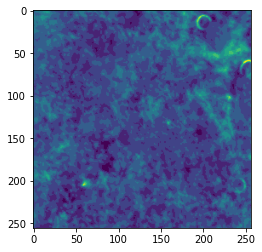

In [93]:
plt.imshow(tiles_milk[100,:,:,2])

In [94]:
tile_pred = model.predict(tiles_milk)

17/17 [==============================] - 53s 3s/step


In [95]:
tile_pred.shape

(526, 256, 256, 1)

In [96]:
driver = gdal.GetDriverByName("GTiff")

In [97]:
driver.Register()

2

In [98]:
def save_predict_milk( nImg, xdim,ydim, img_dir, prefix, orig_dir, file):
    for i in range(T):
        image_path = make_path(img_dir, prefix, file[i])
        tilepath = os.path.join(orig_dir, file[i])
        orig_ds = gdal.Open(tilepath)
        gt = orig_ds.GetGeoTransform()
        pt = orig_ds.GetProjection()
        outTM = driver.Create(image_path, xsize=xdim, ysize=ydim,
                             bands=1, eType=gdal.GDT_Float32)
        outTM.SetGeoTransform(gt)
        outTM.SetProjection(pt)
        outBandTreeM = outTM.GetRasterBand(1)
        outBandTreeM.WriteArray(tile_pred[i, :, :,0])
        outBandTreeM.SetNoDataValue(np.nan)
        outBandTreeM.FlushCache()
        outBandTreeM = None
        outTreeM = None

In [99]:
dirPr = r'/media/hkropp/research/milkweed/predictions/run02'
save_predict_milk(nImg = T,xdim= 256, ydim= 256,img_dir = dirPr,prefix = "predict_",orig_dir = base_dirP, file = tiles)